# Modelos de Regresión

------------------------------------------------------


### Data Science and Machine Learning

#### Febrero 2023

**Aurora Cobo Aguilera**

**The Valley**

------------------------------------------------------

## 2. Regresión *k*-nearest neighbors (*k*NN)

En este notebook describiremos la siguiente tarea de regresión que vamos a estudiar. Se trata de la regresión *k*NN, un modelo no paramétrico.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
import scipy.io       #<-- data = scipy.io.loadmat('concrete.mat') para cargar el dataset
import pandas as pd   

%matplotlib inline 
pylab.rcParams['figure.figsize'] = 9, 6  #<-- Para fijar el tamaño al principio

### 2.1. Cargar los datasets a usar

El dataset es una adaptación del <a href=http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html> dataset `STOCK`</a>, cogido originalmente del repositorio StatLib. El objetivo de este problema es predecir los valores de las acciones de una empresa aeroespacial determinada, dados los valores de otras 9 empresas en el mismo día.  

Puedes explorar los resultados del siguiente notebook usando dos datasets alternativos: 


* El  <a href=https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength> dataset `CONCRETE` </a> obtenido del <a href=https://archive.ics.uci.edu/ml/index.html> repositorio de Machine Learning en la Universidad de California Irvine</a>. Para ello, simplemente elige `CONCRETE` en la variable ds_name y no `STOCK` en la siguiente celda. Recuerda que debes correr las celdas de nuevo para ver los cambios. El objetivo del dataset `CONCRETE` es predecir la fuerza compresiva de mezclas de cemento basadas en variables observadas relacionadas con la composición de la mezcla y la antigüedad del material. 

* El dataset `Advertising`, es obtenido del libro <a href=https://www.statlearning.com/> An Introduction to Statistical Learning with applications in R</a> de los autores: G. James, D. Witten, T. Hastie and R. Tibshirani. El objetivo de dicho problema es predecir las ventas de un producto dado, conociendo la inversión en diferentes sectores de publicidad. Más específicamente, las variables de entrada y salida se describen de la siguiente manera:

  - *Variables de entrada:*
     * TV: dólares de publicidad gastados en TV para un único producto en un mercado determiando (en miles de dólares)
     * Radio: dólares de publicidad gastados en Radio
     * Newspaper: dólares de publicidad gastados en periódicos
     
  - *Variable de salida:*
     * Sales: ventas de un único producto en un mercado determinado (en miles de widgets)
     
Puedes echar un vistazo al archivo `Advertising.csv` para tener una idea de la estructura de los datos.

Empecemos cargando los datos en el espacio de trabajo, y visualizando las dimensiones de todas las matrices.

In [ ]:
# Selecciona el dataset: 'stock', 'concrete' or 'advertising'

#nombre_dataset = input('Qué Archivo quieres abrir? \n 1. stock \n 2. concrete \n 3. advertising \t') #'stock' #<-- escogo el dataset

nombre_dataset = 'stock'

if nombre_dataset == 'stock':
    # STOCK DATASET
    data = scipy.io.loadmat('stock.mat')
    X_tr = data['xTrain']
    Y_tr = data['sTrain']
    X_tst = data['xTest']
    Y_tst = data['sTest']

elif nombre_dataset == 'concrete':
    # CONCRETE DATASET. 
    data = scipy.io.loadmat('concrete.mat')
    X_tr = data['X_tr']
    Y_tr = data['S_tr']
    X_tst = data['X_tst']
    Y_tst = data['S_tst']

elif nombre_dataset == 'advertising':    
    # ADVERTISING DATASET
    df = pd.read_csv('Advertising.csv', header=0)
    X_tr = df.values[:150, 1:4]
    Y_tr = df.values[:150, -1]
    X_tst = df.values[150:, 1:4]
    Y_tst = df.values[150:, -1]

else:
    print('Dataset desconocido')

# Muestra las dimensiones de los datos
print(X_tr.shape)
print(Y_tr.shape)
print(X_tst.shape)
print(Y_tst.shape)

(380, 9)
(380, 1)
(190, 9)
(190, 1)


### 2.2. Visualizar los datos

Podemos obtener una severa idea sobre la tarea de regresión representando el *gráfico disperso* de cada variable unidimensional contra la variable objetivo.

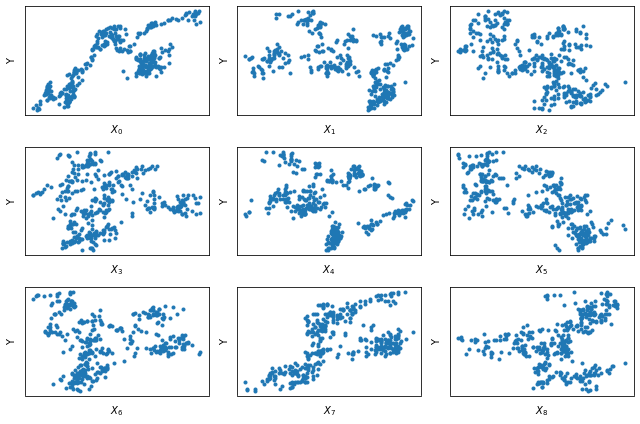

In [ ]:
pylab.subplots_adjust(hspace=0.2)

for idx in range(X_tr.shape[1]):
    ax1 = plt.subplot(3, 3, idx+1) #<-- para asignar un nuevo subplot
    ax1.plot(X_tr[:, idx], Y_tr, '.') #<-- cojo la columnas
    ax1.get_xaxis().set_ticks([]) #<-- quita las etiquetas de datos
    ax1.get_yaxis().set_ticks([])
    ax1.set_xlabel(f'$X_{idx}$')
    ax1.set_ylabel('Y')

plt.tight_layout()
plt.show()

> **Ejercicio**: Modifica la celda anterior para añadir los nombres a los ejes, poniendo X0, X1,... según la variable que se está dibujando, y 'Y' para el eje y con la variable objetivo.

### 2.3. Estimador referencia/*baseline*. Usando la media de la etiquetas del conjunto de entrenamiento

Un primer método muy sencillo para construir un modelo de regresión es usar la media de todos los valores objetivo en el conjunto de entrenamiento como la salida, descartando los valores del vector de las observaciones de entrada.

Este enfoque se puede considerar como un ***baseline***, dado que cualquier otro método haciendo uso efectivo de las variables de entrada, estadísticamente relacionado con $y$, debería mejorarlo.

La predición entonces es dada por


In [ ]:
# Media de todas las varibles objetivo en el conjunto de entranmiento
y_estimada = np.mean(Y_tr)
print(y_estimada)

# Creamos las estimaciones del baseline para entrenamiento y test
y_estimada_train = np.repeat(y_estimada, Y_tr.shape[0]) #<-- repite el primer valor en un array con las filas de Y_tr
y_estimada_test = np.repeat(y_estimada, Y_tst.shape[0])

47.148355263157896


para cualquier entrada ${\bf x}$.

>**Ejercicio**: Calcula el MSE sobre los conjuntos de entrenamiento y test para el método de estimación *baseline*. Para ello utiliza la función de sklearn *mean_squared_error*.


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# MSE del baseline sobre los datos de entrenamiento
MSE_tr = mean_squared_error(Y_tr, y_estimada_train) #<-- usamos el np.repeat() para crear un vector con las filas de Y_tr con el valor de la media y funcionase el MSE
# MSE del baseline sobre los datos de test
MSE_tst = mean_squared_error(Y_tst, y_estimada_test)

print('MSE en el conjunto de entrenamiento (baseline): {0}'.format(MSE_tr))
print('MSE en el conjunto de test (baseline): {0}'.format(MSE_tst))  

MSE en el conjunto de entrenamiento (baseline): 44.14341012378809
MSE en el conjunto de test (baseline): 43.799266901835175


Ten en cuenta que en la pieza de código anterior, la función 'mean_squared_error' no se puede usar cuando el segundo argumento es un número en vez de un vector con la misma longitud que el primer argumento.

### 2.4. Regresión unidimensional con el método $k$-nn

Los principios del método $k$-nn son los siguientes:

   - Para cada muestra donde hay que hacer una predicción, encuentra los $k$ vecinos más cercanos a ella (en el conjunto de entrenamiento)
   - Obtén una estimación promediando las etiquetas correspondientes a los vecinos seleccionados.

El número de vecinos es un hiperparámetro que juega un papel muy importante en el rendimiento del método. 

> **Ejercicio**: Puedes comprobar su influencia cambiando $k$ en el siguiente código. En particular, puedes empezar con $k=1$ y observar el efecto de aumentar el valor de $k$.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

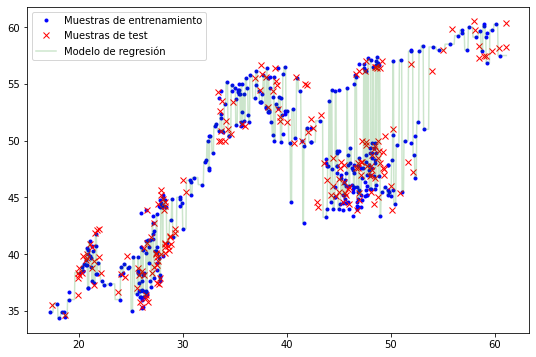

In [ ]:
# Código para implementar regresión unidimensional con K-nn
# Las estimaciones se hacen solo usando una variable de entrada!!

var = 0           # Selecciona la variable (e.g., cualquier valor de 0 a 8 para el dataset STOCK)
k = 1             # Número de vecinos, es el hiperparámetro en este caso
n_points = 1000   # Número de puntos en el eje 'x' (con propósito de representación en gráficas)

X_tr_var = X_tr[:, var].reshape(-1, 1)      # Siempre que añadimos .reshape(-1, 1) es para convertir de vector de 1D a matriz de 2D, igual que hacía np.newaxis
X_tst_var = X_tst[:, var].reshape(-1, 1)

# Para la representación, calculamos la salida del modelo en una serie de puntos igualmente distribuidos en el eje x
grid_min = np.min([np.min(X_tr_var), np.min(X_tst_var)])    # Valor mínimo del eje a representar y evaluar
grid_max = np.max([np.max(X_tr_var), np.max(X_tst_var)])    # Valor máximo del eje a representar y evaluar
X_grid = np.linspace(grid_min, grid_max, num=n_points).reshape(-1, 1)  # <-- Crea en eje de puntos dónde evaluamos el modelo

# Cargamos el modelo a entrenar con el valor elegido para los hiperparámetros 
KNN = KNeighborsRegressor(n_neighbors=k)

# Entrenamos el modelo
KNN.fit(X_tr_var, Y_tr)

# Predecimos en los datos de test y en el grid que vamos a evaluar para las representaciones gráficas
est_tst = KNN.predict(X_tst_var)
est_grid = KNN.predict(X_grid)

# Representamos datos de entrenamiento, datos de test y predicciones en todo el eje
plt.plot(X_tr_var, Y_tr,'b.', label='Muestras de entrenamiento')
plt.plot(X_tst_var, Y_tst,'rx', label='Muestras de test')
plt.plot(X_grid, est_grid,'g-', label='Modelo de regresión ', alpha=0.2)
plt.axis('tight')
plt.legend(loc='best')
plt.show()

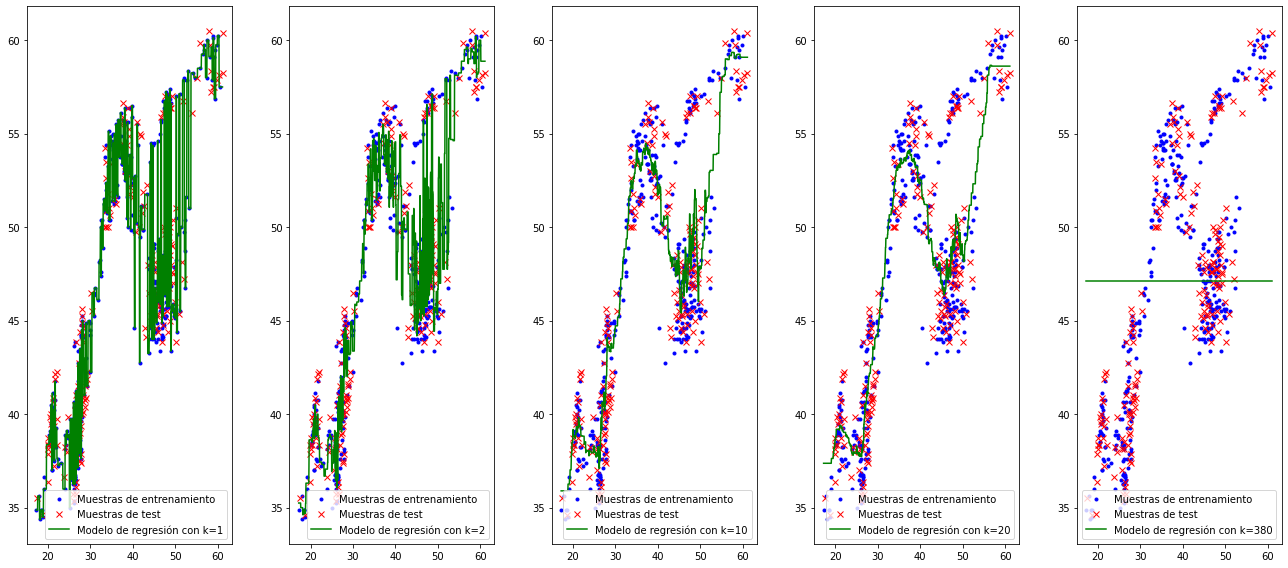

In [ ]:
# Código para implementar regresión unidimensional con K-nn
# Las estimaciones se hacen solo usando una variable de entrada!!
var = 0           # Selecciona la variable (e.g., cualquier valor de 0 a 8 para el dataset STOCK)
k = [1, 2, 10, 20, 380]             # Número de vecinos, es el hiperparámetro en este caso
n_points = 1000   # Número de puntos en el eje 'x' (con propósito de representación en gráficas)

X_tr_var = X_tr[:, var].reshape(-1, 1)      # Siempre que añadimos .reshape(-1, 1) es para convertir de vector de 1D a matriz de 2D, igual que hacía np.newaxis
X_tst_var = X_tst[:, var].reshape(-1, 1)


# Para la representación, calculamos la salida del modelo en una serie de puntos igualmente distribuidos en el eje x
grid_min = np.min([np.min(X_tr_var), np.min(X_tst_var)])    # Valor mínimo del eje a representar y evaluar
grid_max = np.max([np.max(X_tr_var), np.max(X_tst_var)])    # Valor máximo del eje a representar y evaluar
X_grid = np.linspace(grid_min, grid_max, num=n_points).reshape(-1, 1)  # <-- Crea en eje de puntos dónde evaluamos el modelo

fig, ax = plt.subplots(1, len(k), figsize = (18, 8))

for i, x in enumerate(k):
  # Cargamos el modelo a entrenar con el valor elegido para los hiperparámetros
  KNN = KNeighborsRegressor(n_neighbors=x)
  # Entrenamos el modelo
  KNN.fit(X_tr_var, Y_tr)
  # Predecimos en los datos de test y en el grid que vamos a evaluar para las representaciones gráficas
  est_tst = KNN.predict(X_tst_var)
  est_grid = KNN.predict(X_grid)
  ax[i].plot(X_tr_var, Y_tr,'b.', label='Muestras de entrenamiento')
  ax[i].plot(X_tst_var, Y_tst,'rx', label='Muestras de test')
  ax[i].plot(X_grid, est_grid,'g-', label= f'Modelo de regresión con k={x}')
  ax[i].axis('tight')
  ax[i].legend(loc='best')
plt.tight_layout()
plt.show()

#### 2.4.1. Evolución del error con el número de vecinos ($k$)

Podemos ver que un valor pequeño de $k$ resulta en una curva de regresión que presenta muchas oscilaciones grandes. La curva está captando cualquier ruido que pueda estar presente en los datos de entrenamiento y <i>**sobreajusta**</i> el conjunto de entrenamiento. Por otro lado, coger un valor de $k$ muy grande (e.g., 200) hace que la curva de regresión sea muy suave, promediando los valores de las etiquetas en el conjunto de entrenamiento sobre un intervalo muy grande de las variables de observación.

El siguiente código ilustra este efecto, dibujando los errores cuadráticos promedio de entrenamiento y test como una función de $k$. 

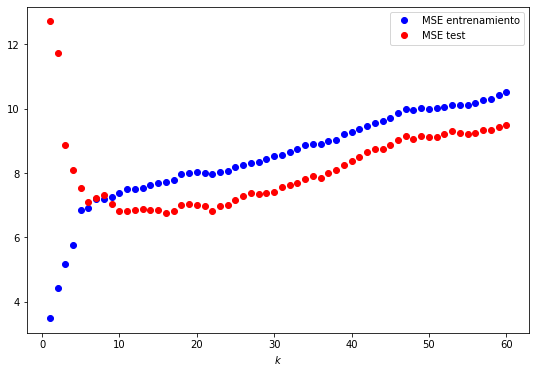

In [ ]:
# Puedes jugar a cambiar estos 2 valores
var = 0
k_max = 60

#<SOL>
#k_max = X_tr.shape[0] 
#</SOL>

k_max = np.minimum(k_max, X_tr.shape[0])  # k_max no puede ser mayor que el número de muestras

# Seleccionamos X de train y de test según la variable escogida
X_tr_var = X_tr[:, var].reshape(-1, 1)      # Siempre que añadimos .reshape(-1, 1) es para convertir de vector de 1D a matriz de 2D, igual que hacía np.newaxis
X_tst_var = X_tst[:, var].reshape(-1, 1)

# Ten cuidado con el uso de range, e.g., range(3) = [0, 1, 2] and range(1, 3) = [1,2]
MSEk_tr = [mean_squared_error(Y_tr, KNeighborsRegressor(k).fit(X_tr_var, Y_tr).predict(X_tr_var)) for k in range(1, k_max+1)]
MSEk_tst = [mean_squared_error(Y_tst, KNeighborsRegressor(k).fit(X_tr_var, Y_tr).predict(X_tst_var)) for k in range(1, k_max+1)]

# Representamos errores de entrenamiento y de test
kgrid = np.arange(1, k_max+1)
plt.plot(kgrid, MSEk_tr, 'bo', label='MSE entrenamiento')
plt.plot(kgrid, MSEk_tst, 'ro', label='MSE test')
plt.xlabel('$k$')
plt.axis('tight')
plt.legend(loc='best')

Como podemos ver, el error inicialmente disminuye alcanzando un mínimo, en el conjunto de test, para algún valor finito de $k$ ($k\approx 10$ para el dataset `STOCK`). Aumentar el valor de $k$ más alla de este número, empobrece el rendimiento del modelo.

>**Ejercicio**: Analiza el MSE para $k=1$. Calcúlalo en la siguiente celda. ¿Por qué es más pequeño que para otros $k$? ¿Bajo qué condiciones será exactamente cero?

In [ ]:
#<SOL>
MSEk_tr[0] #<--porque arriba coge del 1 al k_max = 60
#</SOL>

3.5016447368421053

>**Ejercicio**: Modifica el código anterior para ver el MSE desde $k=1$ hasta $k$ igual al número de muestras de entrenamiento. ¿Puedes relacionar el error cuadrático del método $k$-NN con el *baseline* para algún valor de $k$? 

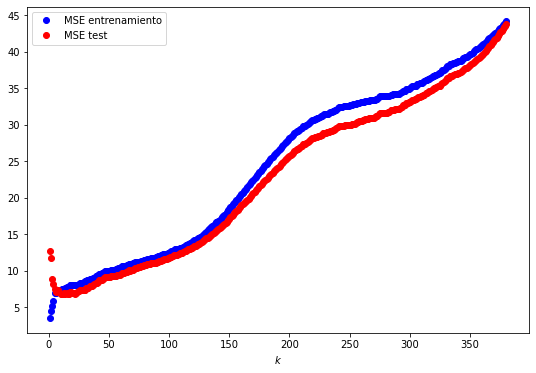

In [ ]:
# Puedes jugar a cambiar estos 2 valores
var = 0
k_max = X_tr.shape[0] 



k_max = np.minimum(k_max, X_tr.shape[0])  # k_max no puede ser mayor que el número de muestras

# Seleccionamos X de train y de test según la variable escogida
X_tr_var = X_tr[:, var].reshape(-1, 1)      # Siempre que añadimos .reshape(-1, 1) es para convertir de vector de 1D a matriz de 2D, igual que hacía np.newaxis
X_tst_var = X_tst[:, var].reshape(-1, 1)

# Ten cuidado con el uso de range, e.g., range(3) = [0, 1, 2] and range(1, 3) = [1,2]
MSEk_tr = [mean_squared_error(Y_tr, KNeighborsRegressor(k).fit(X_tr_var, Y_tr).predict(X_tr_var)) for k in range(1, k_max+1)]
MSEk_tst = [mean_squared_error(Y_tst, KNeighborsRegressor(k).fit(X_tr_var, Y_tr).predict(X_tst_var)) for k in range(1, k_max+1)]

# Representamos errores de entrenamiento y de test
kgrid = np.arange(1, k_max+1)
plt.plot(kgrid, MSEk_tr, 'bo', label='MSE entrenamiento')
plt.plot(kgrid, MSEk_tst, 'ro', label='MSE test')
plt.xlabel('$k$')
plt.axis('tight')
plt.legend(loc='best')
plt.show()

Cuando k=num muestras entonces el MSE coincide con el valor de la media

### 2.4.2. Influencia de la variable de entrada

Echando un ojo a los *scatter plots*, podemos ver que alguna variable de observación parece tener una más clara relación con la variable objetivo. Entonces, podemos esperar que no todas las variables sean igualmente útiles para la tarea de regresión. En la siguiente gráfica estudiamos el rendimiento que puede alcanzar cada variable.

Ten en cuenta que, en la práctica, las etiquetas de test no están accesibles para la selección del hiperparámetro $k$, así que debemos tener cuidado sobre las conclusiones de este experimento. Un enfoque más realista se estudiará más adelante con el concepto de validación del modelo.

Text(0.5, 1.0, 'Selección de los hiperparámetros')

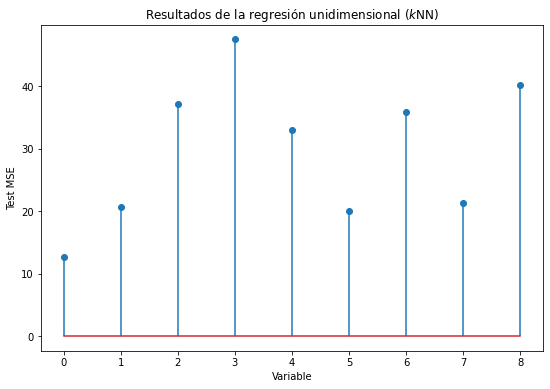

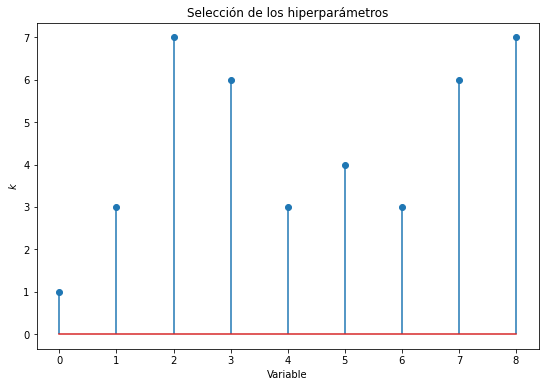

In [ ]:
k_max = 20

performance_variable = []
valores_k = []
for var in range(X_tr.shape[1]): #<-- columnas

    X_tr_var = X_tr[:, var].reshape(-1, 1)      # Siempre que añadimos .reshape(-1, 1) es para convertir de vector de 1D a matriz de 2D, igual que hacía np.newaxis
    X_tst_var = X_tst[:, var].reshape(-1, 1)

    MSE_tr = [mean_squared_error(Y_tr, KNeighborsRegressor(k).fit(X_tr_var, Y_tr).predict(X_tr_var)) for k in range(1, k_max+1)] #<-- calcula el MSE para todos los k en una var
    MSE_tst = [mean_squared_error(Y_tst, KNeighborsRegressor(k).fit(X_tr_var, Y_tr).predict(X_tst_var)) for k in range(1, k_max+1)]

    # Convertimos a array para poder operar con los valores
    MSE_tr = np.asarray(MSE_tr)
    MSE_tst = np.asarray(MSE_tst)

    # Seleccionamos la variable asociada al valor de k para el cual el error es mínimo
    pos = np.argmin(MSE_tr) #<-- nos devulve el índice donde el error es mínimo
    valores_k.append(pos + 1)
    performance_variable.append(MSE_tst[pos])
    
plt.stem(range(X_tr.shape[1]), performance_variable)
plt.title('Resultados de la regresión unidimensional ($k$NN)')
plt.xlabel('Variable')
plt.ylabel('Test MSE')

plt.figure(2)
plt.stem(range(X_tr.shape[1]), valores_k)
plt.xlabel('Variable')
plt.ylabel('$k$')
plt.title('Selección de los hiperparámetros')

### 2.5. Regresión multidimensional con el método $k$-nn

En la sección anterior, hemos estudiado el rendimiento del método $k$-nn cuando sólo usamos una variable. Hacer esto era conveniente, porque nos permitía dibujar las curvas de regresión en una figura de 2D y tener una idea sobre las consecuencias de modificar el número de vecinos.

Para completarlo, evaluamos el rendimiento del método $k$-nn en este dataset usando todas las variables juntas. De hecho, cuando diseñas un modelo de regresión, deberías proceder de esta manera, usando toda la información disponible para hacer una estimación lo más precisa posible. De esta forma, podremos también darnos cuenta de posibles correlaciones que pueda haber entre las variables de entrada y que puedan tener información relevante para la tarea de regresión.

Por ejemplo, en el dataset `STOCK`, podría ser que la combinación de las acciones de dos empresas de aviones sea más informativa sobre el precio objetivo de la empresa, mientras que el valor de una compañia sólo no es suficiente.


También, en el dataset `CONCRETE`, podría ser que para el problema que se trata la combinación de una gran proporción de agua con una pequeña proporción de grano grueso es un claro indicador de cierta fuerza compresiva del material, mientras la proporción de alguna de las dos sustancias por separado no sea sufiecientemente buena para obtener ere resultado.




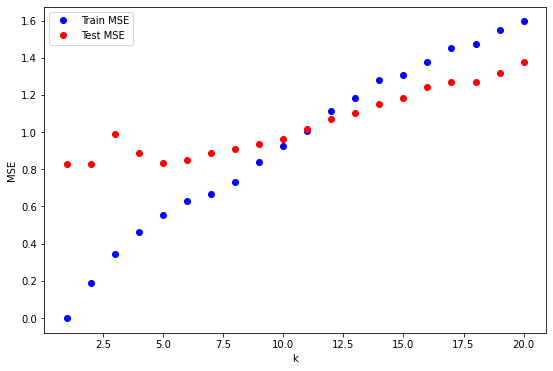

In [ ]:
k_max = 20

# Ahora cogemos todos los datos y no sólo una variable
MSE_tr = [mean_squared_error(Y_tr, KNeighborsRegressor(k).fit(X_tr, Y_tr).predict(X_tr)) for k in range(1, k_max+1)]
MSE_tst = [mean_squared_error(Y_tst, KNeighborsRegressor(k).fit(X_tr, Y_tr).predict(X_tst)) for k in range(1, k_max+1)]


plt.plot(np.arange(k_max)+1, MSE_tr,'bo',label='Train MSE')
plt.plot(np.arange(k_max)+1, MSE_tst,'ro',label='Test MSE')
plt.xlabel('k')
plt.ylabel('MSE')

plt.legend(loc='best')

### 2.6. Selección de los hiperparámeteros via **cross-validation**

Un inconveniente de la aplicación del método $k$-nn es que la selección de $k$ influye el error final del algoritmo. En experimentos anteriores, mantenemos el valor de $k$ que minimiza el MSE en el conjunto de entrenamiento. Sin embargo, vimos que la localización del mínimo no es necesariamente la misma desde la perspectiva de los datos de test. Idealmente, nos gustaría que el diseño del modelo de regresión funcione tan bien como sea posible para futuros patrones sin etiquetar que no están disponibles durante la fase de entrenamiento. Esta propiedad se llama <i>generalización</i>. Ajustamos los datos de entrenamiento con la esperanza de indirectamente obtener también un modelo que generalice bien. Para conseguir dicho objetivo, hay estrategias que intentan garantizar una correcta generalización del modelo. Una de dichas estrategias se conoce como validación cruzada o <b>cross-validation</b>, en inglés.

Ya que no se permite usar las etiquetas de test durante el entrenamiento (debería dejarse para simular posible aplicaciones futuras del modelo en patrones no observados), necesitamos averiguar una manera de mejorar nuestra estimación de los hiperparámetros que requiera solo datos de entrenamiento.Cross-validation nos permite hacer esto siguiendo una serie de pasos: 

   - Dividir el conjunto de entrenamiento en diferentes subconjuntos (generalmente no superpuestos). Si usamos $M$ subconjuntos, el método es definido como **$M$-fold cross-validation**. Si consideramos cada muestra como un conjunto diferente, el método es definido como **leave-one-out (LOO) cross-validation**.
   - Entrena el sistema $M$ veces. Para cada ejecución, usa diferentes particiones como el conunto de <i>validación</i>, y usa el resto como conjunto de entrenamiento. Evalua el rendimiento para diferentes elecciones del hiperparámetro (i.e., para diferentes valores de $k$ para el método $k$-NN).
   - Promedia el error de validación sobre todas las paritciones, y escoge el hiperparámetro que proporcione el mínimo error de validación.
   - Vuelve a ejecutar el algoritmo sobre todas las muestras de entrenamiento, manteniendo el valor del hiperparámetro que elegiste del proceso de cross-validation.
   
<img src="https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png">

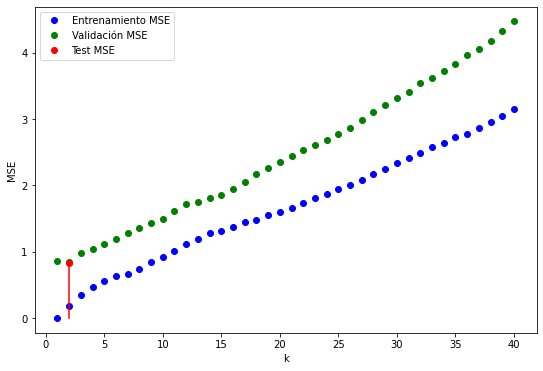

In [ ]:
### Este fragmento de código ejecuta k-nn con validación cruzada M-fold 

# Parámetros:
M = 5       # Número de subconjuntos para M-cv
k_max = 40  # Máximo valor del parámetro k del knn que se va a explorar

# Primero calculamos la curva del error de entrenamiento, que va a ser útil para comparación visual
MSE_tr = [mean_squared_error(Y_tr, KNeighborsRegressor(k).fit(X_tr, Y_tr).predict(X_tr)) for k in range(1, k_max+1)]

## M-CV
# Obtenemos los índices de las observaciones para los diferentes subconjuntos
n_tr = X_tr.shape[0]
permutacion = np.random.permutation(n_tr)

# Dividimos los índices en M subconjuntos de (casi) el mismo tamaño. 
conjuntos_indices = {i: [] for i in range(M)}
i = 0
for pos in range(n_tr):
    conjuntos_indices[i].append(permutacion[pos])
    i = (i+1) % M
    
# Obtenemos los errores de validacion
MSE_val = np.zeros((1,k_max))
for i in range(M):
    val_indices = conjuntos_indices[i]
    
    # Sacamos los val_indices del conjunto de índices.
    tr_indices = list(set(permutacion) - set(val_indices))
    
    MSE_val_iter = [mean_squared_error(Y_tr[val_indices], KNeighborsRegressor(k).fit(X_tr[tr_indices, :], Y_tr[tr_indices]).predict(X_tr[val_indices, :])) for k in range(1, k_max+1)]

    MSE_val = MSE_val + np.asarray(MSE_val_iter).T
    
MSE_val = MSE_val/M

# Selecciona el mejor k basado en el error de validación
k_mejor = np.argmin(MSE_val) + 1

# Calcula el MSE de test final para el k seleccionado
MSE_tst = mean_squared_error(Y_tst, KNeighborsRegressor(k_mejor).fit(X_tr, Y_tr).predict(X_tst))

plt.plot(np.arange(k_max)+1, MSE_tr, 'bo', label='Entrenamiento MSE')
plt.plot(np.arange(k_max)+1, MSE_val.T, 'go', label='Validación MSE')
plt.plot([k_mejor, k_mejor], [0, MSE_tst],'r-')
plt.plot(k_mejor, MSE_tst,'ro',label='Test MSE')
plt.legend(loc='best')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()

Para los próximos notebooks usaremos la librería de Sklearn también para hacer validación cruzada, por lo que puedes ignorar el código anterior. Se ha usado simplemente con méritos de entender cómo funciona esta estragia.

> **Ejercicio**: Modifica el código anterior para usar sólo una de las variables de entrada en el dataset.
  - Siguiendo un enfoque de validación cruzada, selecciona el mejor valor de $k$ para el $k$-nn basado solo en la variable 0.
  - Calcula el error de test para el valor seleccionado de $k$.

In [ ]:
#<SOL>

#</SOL>

### 2.7. Ahora tú! Ejemplo de implementación del KNN en Scikit-learn

En la práctica, los modelos más conocidos de ML están implementados y disponibles para python. Probablemente, uno de los módulos/librerías más completos para herramientas de ML es <a href=http://scikit-learn.org/stable/>Scikit-learn</a>. En la siguiente pieza de código debes utilizar el método

    KNeighborsRegressor
   
disponible en Scikit-learn, como se ha hecho anteriormente en el notebook. A continuación mostramos un ejemplo que se ha tomado de <a href=http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html>aquí</a>. Como puedes comprobar, esta rutina permite construir la estimación de una muestra en particular usando la media ponderada de los vecinos objetivo: 

   Para obtener la estimación de una muestra ${\bf x}$:
   
   - Encuentra las $k$ muestras más cercanas a ${\bf x}$ en el conjunto de entrenamiento.
   - Promedia las correspondientes muestras objetivo, ponderando cada valor de acuerdo a la distancia de cada muestra a ${\bf x}$, de manera que las muestras más cercanas tienen mayor influencia en la estimación.


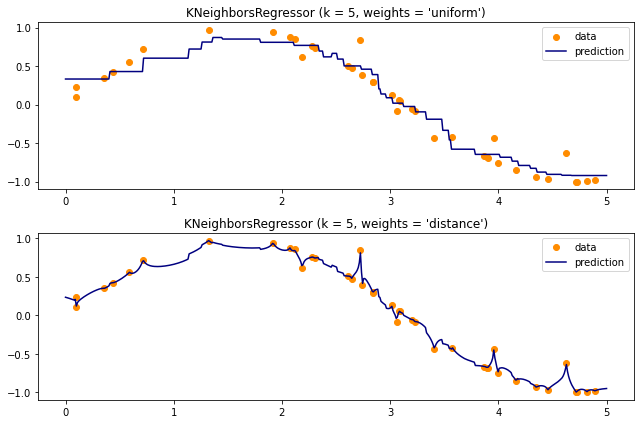

In [ ]:
# Generamos las observaciones de los datos
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Añadimos ruido al 'target'
y[::5] += 1 * (0.5 - np.random.rand(8))


# Ajustamos el modelo de regresión
n_neighbors = 5

for i, weights in enumerate(["uniform", "distance"]):
    # Creamos el modelo
    knn = KNeighborsRegressor(n_neighbors, weights=weights)
    # Entrenamos el modelo y predecimos las salidas de los datos
    knn.fit(X, y)
    y_ = knn.predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, color="darkorange", label="data")
    plt.plot(T, y_, color="navy", label="prediction")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.tight_layout()
plt.show()


> **Ejercicio**: Investiga qué significa el parámetro __weights__ que usa el código anterior. O, intuyelo a través de la gráfica obtenida.

> **Ejercicio**: Utiliza la implementación de scikit-learn para el método $k$-nn para calcular el error de generalización en el dataset `CONCRETE`. Compara el resultado cuando usas pesos uniformes con respecto a los basados en distancia en el cálculo de la estimación. Visualiza las curvas de regresión y el error para diferentes valores de $k$.

In [ ]:
data = scipy.io.loadmat('concrete.mat')
X_tr  = data['X_tr']
Y_tr = data['S_tr']
X_tst = data['X_tst']
Y_tst = data['S_tst']
X_tr.shape[0]

824

In [ ]:
k_max = X_tr.shape[0]
k_values = [i for i in np.arange(1, 20)]


MSE_tr = [[mean_squared_error(Y_tr, KNeighborsRegressor(k, weights=weights).fit(X_tr, Y_tr).predict(X_tr)) for k in k_values] \
          for weights in ("uniform", "distance") ]
MSE_tst = [[mean_squared_error(Y_tst, KNeighborsRegressor(k, weights=weights).fit(X_tr, Y_tr).predict(X_tst)) for k in k_values ] \
           for weights in ("uniform", "distance") ]

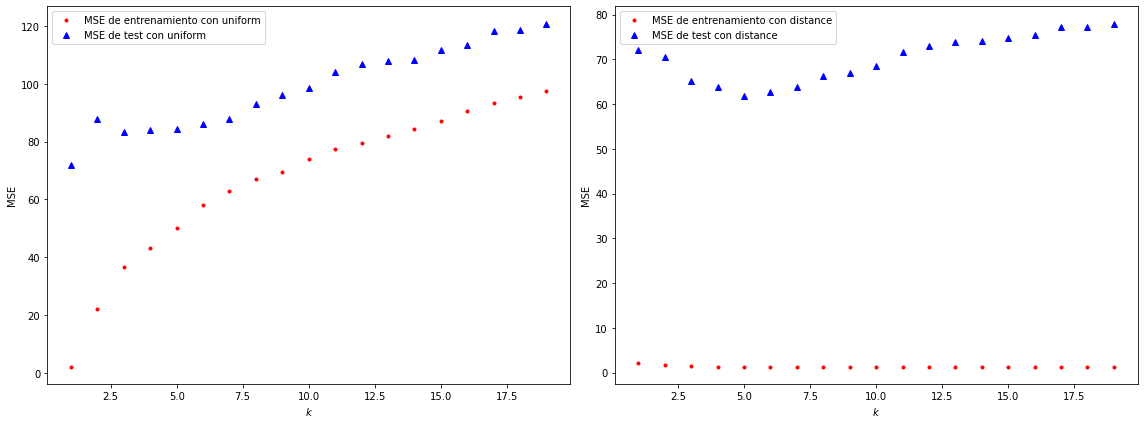

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
weights = ["uniform", "distance"]
for i, x in enumerate(ax):
  ax[i].plot(k_values, MSE_tr[i], 'r.', label = f'MSE de entrenamiento con {weights[i]}')
  ax[i].plot(k_values, MSE_tst[i], 'b^', label = f'MSE de test con {weights[i]}')
  ax[i].set_xlabel('$k$')
  ax[i].set_ylabel('MSE')
  ax[i].legend(loc='best')

plt.tight_layout()
plt.show()